## Contents of this notebook

Here we will explore the four methods of extracting the global spectrum of a flow (here atmospheric winds in the year 2020) using the software Flowsieve.

1. Extracting the spectrum from "coarse KE coarsened map"
2. Spectrum from "coarse KE area average"
3. From "ulon and ulat spectrum avg"
4. From "ulon and ulat spectrum coarsened map"

## 1. Extracting the spectrum from "coarse KE coarsened map"

Coarse refers to the kinetic energy contained in scales greater than our filter scale. It is the result of locally averaging our u and v velocity fields and then calculating the resulting kinetic energy. "Coarsened map" refers to the fact we have put our results on a 2-degree by 2-degree grid instead of the native 12th-of-a-degree grid the calculations were performed on.

To calculate the spectrum from coarse KE (provided it has been calculated for more than one filtering scale), one can take the derivative with respect to the filtering scale. This tells us how much energy is added when we use a finer filtering kernel.

For consistency with Fourier methods, we will actually take the derivative with respect to the wavenumber, which is given by $k = 2\pi/l$ where l is in meters and k is in rad/m.

If we were to take the derivative with respect to $1/l$ which would also be valid, the magnitude of our results would deviate by $2\pi$ from Fourier method spectra.

Since KE is calculated assuming density is 1025 kg/m$^3$ we divide by 1025 before plotting our result, so we are really concerned with KE per unit mass.

In [1]:
from netCDF4 import Dataset
import numpy as np

In [2]:
R = 6371e3  # Earth's radius in meters

with Dataset(f'../IFSAnalysis/Data/Jan20012IFS_full.nc', 'r') as dset:
    clat = dset['coarse_latitude'][:] 
    clon = dset['coarse_longitude'][:] 

coarse_areas = np.zeros((len(clat), len(clon)))

for i in range(len(clat)):
    for j in range(len(clon)):
        # Define latitudes and longitudes for the current grid cell
        if i == len(clat) - 1:
            lat1 = clat[i]
            lat2 = np.pi / 2
        else:
            lat1 = clat[i]
            lat2 = clat[i + 1]
        
        if j == len(clon) - 1:
            lon1 = clon[j]
            lon2 = 2 * np.pi
        else:
            lon1 = clon[j]
            lon2 = clon[j + 1]

        # Calculate the area using the spherical approximation
        area = R**2 * abs(np.sin(lat2) - np.sin(lat1)) * abs(lon2 - lon1)
        coarse_areas[i, j] = area


In [3]:
with Dataset(f'../IFSAnalysis/Data/Jan20012IFS_full.nc', 'r') as dset:
    ell = dset['ell'][0:19]                                       #filter length scales l "ell"
    cLat = dset['coarse_latitude'][:]                             #coarse latitude, 2 degree increments from -pi to pi, in radians used for weighting
    cKE = dset['coarse_KE_coarsened_map'][0:19, :, 0, :, :]       #coarse KE coarsened map, ell, time, level (0 as only 1 level), lat, lon

    weighted_cKE_sum = np.sum(cKE * coarse_areas[np.newaxis, np.newaxis, :, :], axis=(1, 2, 3))
    total_area = np.sum(coarse_areas) * np.shape(cKE)[1]
    cKE_combined_avg = weighted_cKE_sum / total_area
    

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from FiniteDiff import FiniteDiff 

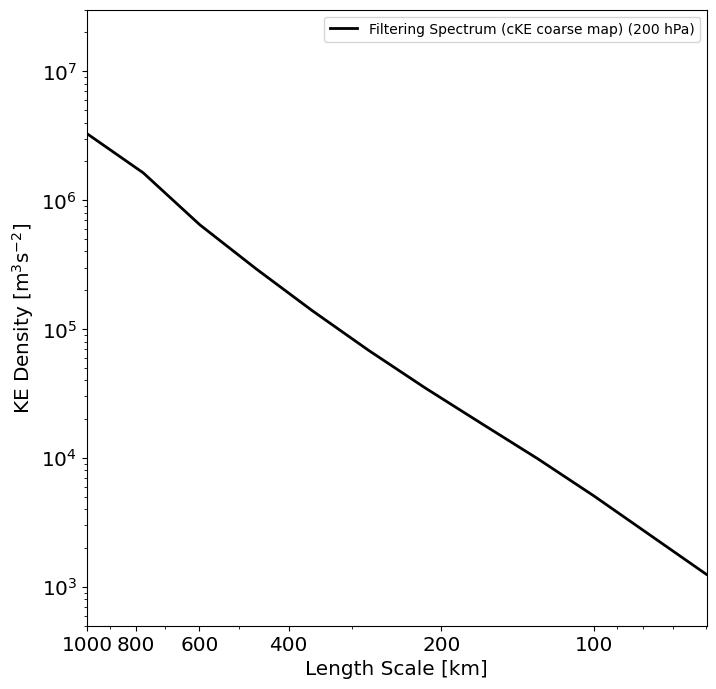

In [5]:
plt.figure(figsize=(8, 8))
with Dataset('../IFSAnalysis/Data/Jan20012IFS_full.nc', 'r') as dset:
    ell = dset['ell'][0:19]
    
ymin = 5e2
ymax = 3e7

filterWavenums = 2 * np.pi / np.array(ell[0:19])
FILTER_SCALES_km = np.array(ell[0:19]) / 1000

ddk_1D = FiniteDiff(2*np.pi/ell, 4, Sparse=True, Periodic=False, Uniform=False)

spec_avg_derivative_total = ddk_1D.dot(cKE_combined_avg)

plt.plot(FILTER_SCALES_km[5:], spec_avg_derivative_total[5:]/1025, color='black', label=f"Filtering Spectrum (cKE coarse map) (200 hPa)",linewidth=2)

plt.xscale('log')
plt.yscale('log')
min_scale, max_scale = FILTER_SCALES_km[7:].min(), FILTER_SCALES_km[5:19].max()
plt.xlim(max_scale, min_scale)
plt.ylim(ymin, ymax)

plt.xlabel('Length Scale [km]', fontsize='x-large')
plt.ylabel('KE Density [m$^3$s$^{-2}$]', fontsize='x-large')

x_ticks = [100, 200, 400, 600, 800, 1000]  
plt.xticks(x_ticks, labels=[str(x) for x in x_ticks], fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid(False)

plt.legend()
plt.show()

## 2. Spectrum from "Coarse KE area average"

Flowsieve also does the averaging in different regions internally. It does this globally, in the tropics, south of the tropics, and north of the tropics. These are indexed 0, 1, 2, and 3, respectively.

Again we must divide by the density.

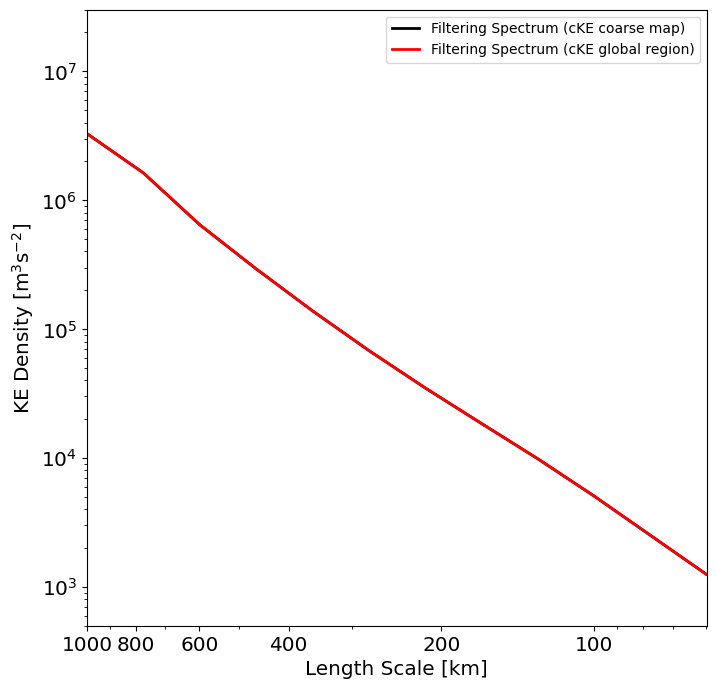

In [6]:
plt.figure(figsize=(8, 8))
with Dataset('../IFSAnalysis/Data/Jan20012IFS_full.nc', 'r') as dset:
    ell = dset['ell'][0:19]
    KEglobal = np.mean(dset['coarse_KE_area_average'][0:19,:,0,0],axis=1)   #dimensions are ell, time, depth, region

ddk_1D = FiniteDiff(2*np.pi/ell, 4, Sparse=True, Periodic=False, Uniform=False)
spec_avg_derivative_total_ckeg = ddk_1D.dot(KEglobal)

ymin = 5e2
ymax = 3e7

plt.plot(FILTER_SCALES_km[5:], spec_avg_derivative_total[5:]/1025, color='black', label=f"Filtering Spectrum (cKE coarse map)",linewidth=2)

plt.loglog(FILTER_SCALES_km[5:], spec_avg_derivative_total_ckeg[5:]/1025, color='red', label=f"Filtering Spectrum (cKE global region)",linewidth=2)

plt.xscale('log')
plt.yscale('log')
min_scale, max_scale = FILTER_SCALES_km[7:].min(), FILTER_SCALES_km[5:19].max()
plt.xlim(max_scale, min_scale)
plt.ylim(ymin, ymax)

plt.xlabel('Length Scale [km]', fontsize='x-large')
plt.ylabel('KE Density [m$^3$s$^{-2}$]', fontsize='x-large')

x_ticks = [100, 200, 400, 600, 800, 1000]  
plt.xticks(x_ticks, labels=[str(x) for x in x_ticks], fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid(False)

plt.legend()



## 3. Spectrum from "ulon and ulat spectrum avg"

Flowsieve also has the spectrum itself, calculated internally by using the analytic expression for the derivative of the kernel. However, this derivative is done with respect to 1/length without the $2\pi$ conversion. Thus, when comparing we divide by $2\pi$. As always we must also divide by density.

For some reason, doing the derivative at analytically seems to cause the effective resolution to go down. 

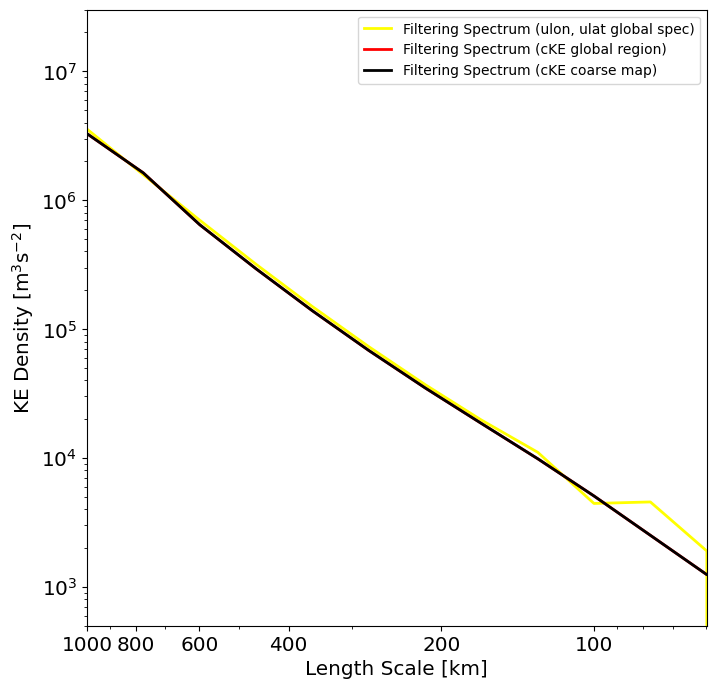

In [7]:
plt.figure(figsize=(8, 8))
with Dataset('../IFSAnalysis/Data/Jan20012IFS_full.nc', 'r') as dset:
    ell = dset['ell'][0:19]
    uspecglobal = np.mean(dset['u_lon_spectrum_area_average'][0:19,:,0,0],axis=1)
    vspecglobal = np.mean(dset['u_lat_spectrum_area_average'][0:19,:,0,0],axis=1)

plt.loglog(FILTER_SCALES_km[5:], (uspecglobal[5:]+vspecglobal[5:])/(2*np.pi*1025), color='yellow', label=f"Filtering Spectrum (ulon, ulat global spec)",linewidth=2)

plt.loglog(FILTER_SCALES_km[5:], spec_avg_derivative_total_ckeg[5:]/1025, color='red', label=f"Filtering Spectrum (cKE global region)",linewidth=2)

plt.plot(FILTER_SCALES_km[5:], spec_avg_derivative_total[5:]/1025, color='black', label=f"Filtering Spectrum (cKE coarse map)",linewidth=2)

ymin = 5e2
ymax = 3e7

plt.xscale('log')
plt.yscale('log')
min_scale, max_scale = FILTER_SCALES_km[7:].min(), FILTER_SCALES_km[5:19].max()
plt.xlim(max_scale, min_scale)
plt.ylim(ymin, ymax)

plt.xlabel('Length Scale [km]', fontsize='x-large')
plt.ylabel('KE Density [m$^3$s$^{-2}$]', fontsize='x-large')

x_ticks = [100, 200, 400, 600, 800, 1000]  
plt.xticks(x_ticks, labels=[str(x) for x in x_ticks], fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid(False)

plt.legend()

## 4. Spectrum from "ulon and ulat spectrum coarsened map"

We also have the spectrum on the coarsened map. So we can directly do an area average to extract the global spectrum from this. We divide by density and $2\pi$ once again.

In [8]:
with Dataset(f'../IFSAnalysis/Data/Jan20012IFS_full.nc', 'r') as dset:
    ell = dset['ell'][0:19]                                       #filter length scales l "ell"
    cLat = dset['coarse_latitude'][:]                             #coarse latitude, 2 degree increments from -pi to pi, in radians used for weighting
    ulon = dset['u_lon_spectrum_coarsened_map'][0:19, :, 0, :, :]
    ulat = dset['u_lat_spectrum_coarsened_map'][0:19, :, 0, :, :]

    KE_combined_weighted = np.sum((ulon+ulat) * coarse_areas[np.newaxis, np.newaxis, :, :], axis=(1, 2, 3))
    total_area = np.sum(coarse_areas) * np.shape(cKE)[1]
    KE_combined_avg = KE_combined_weighted / total_area
    

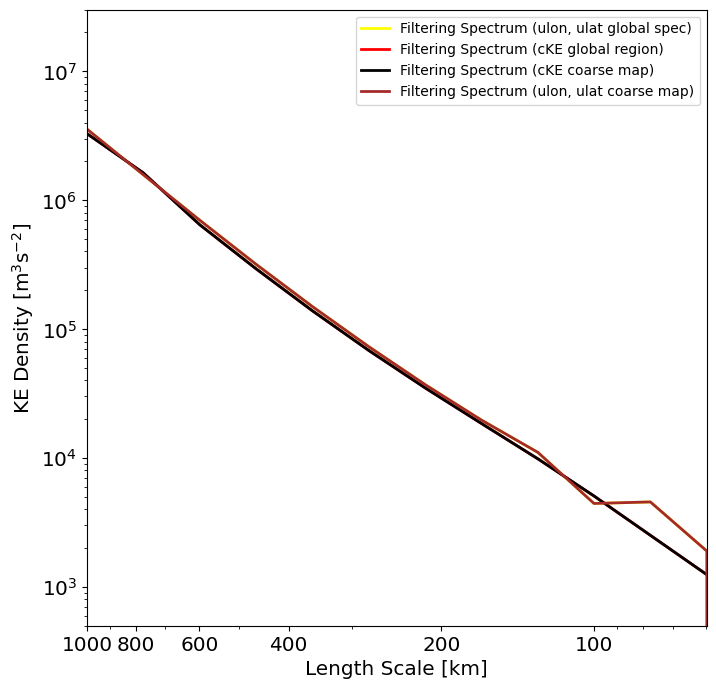

In [9]:
plt.figure(figsize=(8, 8))


plt.loglog(FILTER_SCALES_km[5:], (uspecglobal[5:]+vspecglobal[5:])/(2*np.pi*1025), color='yellow', label=f"Filtering Spectrum (ulon, ulat global spec)",linewidth=2)

plt.loglog(FILTER_SCALES_km[5:], spec_avg_derivative_total_ckeg[5:]/1025, color='red', label=f"Filtering Spectrum (cKE global region)",linewidth=2)

plt.plot(FILTER_SCALES_km[5:], spec_avg_derivative_total[5:]/1025, color='black', label=f"Filtering Spectrum (cKE coarse map)",linewidth=2)

plt.loglog(FILTER_SCALES_km[5:], KE_combined_avg[5:]/(2*np.pi*1025), color='brown', label=f"Filtering Spectrum (ulon, ulat coarse map)",linewidth=2)

ymin = 5e2
ymax = 3e7

plt.xscale('log')
plt.yscale('log')
min_scale, max_scale = FILTER_SCALES_km[7:].min(), FILTER_SCALES_km[5:19].max()
plt.xlim(max_scale, min_scale)
plt.ylim(ymin, ymax)

plt.xlabel('Length Scale [km]', fontsize='x-large')
plt.ylabel('KE Density [m$^3$s$^{-2}$]', fontsize='x-large')

x_ticks = [100, 200, 400, 600, 800, 1000]  
plt.xticks(x_ticks, labels=[str(x) for x in x_ticks], fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid(False)

plt.legend()